In [ ]:
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import os
from transformers import SegformerForSemanticSegmentation, AutoImageProcessor
from torch.optim import Adam
import matplotlib.pyplot as plt
import numpy as np
import torch.nn.functional as F

In [ ]:
# Désactiver l'avertissement sur les symlinks (optionnel, utile sur Windows)
os.environ["HF_HUB_DISABLE_SYMLINKS_WARNING"] = "1"

# Définir le chemin vers le dataset LoveDa
dataset_dir = r'C:\Users\LOQ\Desktop\Data'

# Liste des classes pour LoveDa
classes = ['background', 'building', 'road', 'water', 'barren', 'forest', 'agricultural']
num_classes = len(classes)

In [ ]:
# Dataset personnalisé pour la segmentation sémantique avec LoveDa
class LoveDaSegmentationDataset(Dataset):
    def __init__(self, root_dir, split='Train', transform=None, target_transform=None):
        self.image_paths = []
        self.mask_paths = []
        self.transform = transform
        self.target_transform = target_transform

        for region in ['Urban', 'Rural']:
            image_dir = os.path.join(root_dir, split, region, 'images_png')
            mask_dir = os.path.join(root_dir, split, region, 'masks_png')

            for filename in os.listdir(image_dir):
                if filename.endswith(".png"):
                    self.image_paths.append(os.path.join(image_dir, filename))
                    self.mask_paths.append(os.path.join(mask_dir, filename))

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = Image.open(self.image_paths[idx]).convert('RGB')
        mask = Image.open(self.mask_paths[idx])

        if self.transform:
            image = self.transform(image)

        if self.target_transform:
            mask = self.target_transform(mask)

        return image, mask

In [ ]:
# Transformations pour l'image et le masque
image_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

def mask_transform(mask):
    mask = mask.resize((224, 224), resample=Image.NEAREST)
    mask = np.array(mask)
    mask = np.clip(mask, 0, num_classes - 1)  # Clip les valeurs pour qu'elles soient entre 0 et num_classes - 1
    return torch.tensor(mask, dtype=torch.long)

# Charger le dataset
dataset = LoveDaSegmentationDataset(root_dir=dataset_dir, split='Train',transform=image_transform, target_transform=mask_transform)
dataloader = DataLoader(dataset, batch_size=4, shuffle=True)

# Charger le modèle Segformer pour la segmentation sémantique
model = SegformerForSemanticSegmentation.from_pretrained(
    'nvidia/mit-b0',  # Segformer b0 (un ViT adapté à la segmentation)
    num_labels=num_classes,
    ignore_mismatched_sizes=True
)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Optimiseur et fonction de perte
optimizer = Adam(model.parameters(), lr=1e-4)
criterion = nn.CrossEntropyLoss(ignore_index=num_classes)

In [ ]:
# Fonction d'entraînement pour la segmentation sémantique
def train_model(model, dataloader, optimizer, criterion, device, num_epochs=5):
    model.train()
    for epoch in range(num_epochs):
        running_loss = 0.0
        for images, masks in dataloader:
            images = images.to(device)
            masks = masks.to(device)

            optimizer.zero_grad()
            outputs = model(pixel_values=images).logits  # [batch_size, num_classes, height, width]

            # Redimensionner les prédictions à la taille des masques cibles
            outputs = F.interpolate(outputs, size=masks.shape[1:], mode='bilinear', align_corners=False)

            loss = criterion(outputs, masks)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        avg_loss = running_loss / len(dataloader)
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}")

# Entraîner le modèle (exemple)
train_model(model, dataloader, optimizer, criterion, device, num_epochs=20)

In [ ]:
# Fonction de prédiction et d'affichage des résultats de segmentation
def predict_and_display(model, image_path, device):
    model.eval()
    image = Image.open(image_path).convert('RGB')
    input_image = image_transform(image).unsqueeze(0).to(device)

    with torch.no_grad():
        outputs = model(pixel_values=input_image).logits
        outputs = F.interpolate(outputs, size=(224, 224), mode='bilinear', align_corners=False)
        predicted_mask = torch.argmax(outputs, dim=1).squeeze(0).cpu().numpy()

    # Afficher l'image originale et le masque prédit
    fig, ax = plt.subplots(1, 2, figsize=(12, 6))
    ax[0].imshow(image)
    ax[0].set_title("Image Originale")
    ax[1].imshow(predicted_mask, cmap='jet')
    ax[1].set_title("Masque Prédit")
    plt.show()


Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/mit-b0 and are newly initialized: ['decode_head.batch_norm.bias', 'decode_head.batch_norm.num_batches_tracked', 'decode_head.batch_norm.running_mean', 'decode_head.batch_norm.running_var', 'decode_head.batch_norm.weight', 'decode_head.classifier.bias', 'decode_head.classifier.weight', 'decode_head.linear_c.0.proj.bias', 'decode_head.linear_c.0.proj.weight', 'decode_head.linear_c.1.proj.bias', 'decode_head.linear_c.1.proj.weight', 'decode_head.linear_c.2.proj.bias', 'decode_head.linear_c.2.proj.weight', 'decode_head.linear_c.3.proj.bias', 'decode_head.linear_c.3.proj.weight', 'decode_head.linear_fuse.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch [1/20], Loss: 0.9603
Epoch [2/20], Loss: 0.7384
Epoch [3/20], Loss: 0.6841
Epoch [4/20], Loss: 0.6327
Epoch [5/20], Loss: 0.5971
Epoch [6/20], Loss: 0.5690
Epoch [7/20], Loss: 0.5330
Epoch [8/20], Loss: 0.5095
Epoch [9/20], Loss: 0.4913
Epoch [10/20], Loss: 0.4863
Epoch [11/20], Loss: 0.4637
Epoch [12/20], Loss: 0.4432
Epoch [13/20], Loss: 0.4317
Epoch [14/20], Loss: 0.4189
Epoch [15/20], Loss: 0.4151
Epoch [16/20], Loss: 0.4046
Epoch [17/20], Loss: 0.4074
Epoch [18/20], Loss: 0.3802
Epoch [19/20], Loss: 0.3781
Epoch [20/20], Loss: 0.3671


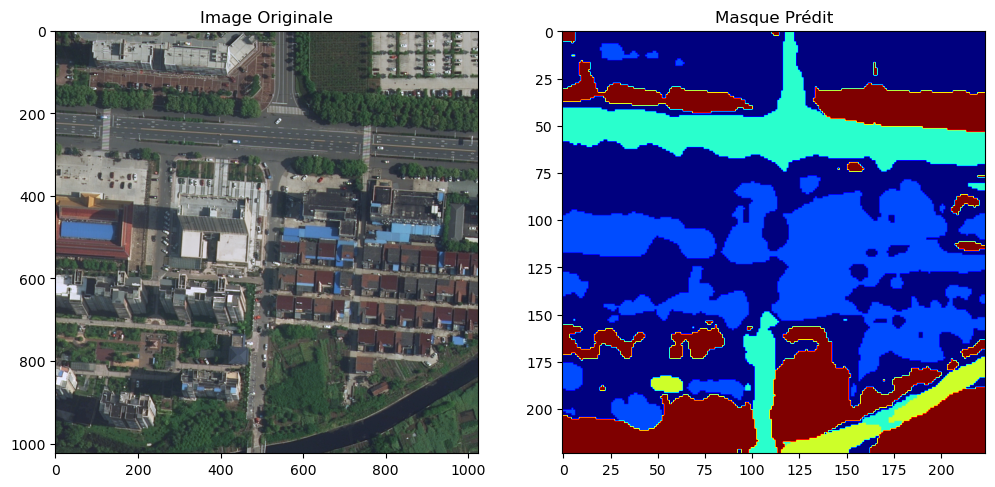

In [ ]:
# Exemple de prédiction
example_image_path = os.path.join(dataset_dir, 'Test', 'Urban', 'images_png', '3515.png')
predict_and_display(model, example_image_path, device)